<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Data Description

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

```
Dependent features: 1 (price)
Features : 19 home features
Id: 1 house ID
Task: Estimate the price based on given features.
```

# Business Problem

<div class="alert alert-block alert-success">
<b>Business Problem:</b>  <br>
Task &nbsp;&nbsp; : Predict the house price based on King County Seattle House price data. <br>
Metric : RMSE <br>
General Model: SVR, Ridge, Random Forest <br>
Boosting: Gradient Boosting, xgb, lgb
Tools: Stakcing multiple regressors to train and blending them to predit<br>
Question: What is the price of new house?
</div>

# Imports

In [1]:
import time

time_start_notebook = time.time()

In [2]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install watermark
    !pip install catboost
    !pip install shap
    !pip install mlxtend

    # if we update existing module, we need to restart colab
    !pip install -U scikit-learn

    ## print
    print('Environment: Google Colaboratory.')
TREE_METHOD = 'gpu_hist' if ENV_COLAB else 'auto'

In [3]:
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# mixed
import os
import time
from pprint import pprint

# random state
SEED=100
np.random.seed(SEED)

# settings
pd.set_option('display.max_columns', 200)

# sklearn
import sklearn
from sklearn import linear_model # Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn import svm # SVR
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline
from sklearn import decomposition # PCA
from sklearn.inspection import permutation_importance

# boosting
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost
import lightgbm
import catboost

# special
import mlxtend
from mlxtend.regressor import StackingCVRegressor

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-11-06 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit

numpy      1.18.5
sklearn    0.23.2
xgboost    0.90
pandas     1.1.4
lightgbm   2.2.3
catboost   0.24.2
matplotlib 3.2.2
watermark  2.0.2
mlxtend    0.14.0
seaborn    0.11.0



In [4]:
!nvidia-smi

Fri Nov  6 12:36:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Important Scripts

In [5]:
def show_methods(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [6]:
def adjustedR2(rsquared,nrows,ncols):
    return rsquared- (ncols-1)/(nrows-ncols) * (1-rsquared)

In [7]:
def print_regr_eval(ytest,ypreds,ncols):
    rmse = np.sqrt(metrics.mean_squared_error(ytest,ypreds))
    r2 = metrics.r2_score(ytest,ypreds)
    ar2 = adjustedR2(r2,len(ytest),ncols)
    evs = metrics.explained_variance_score(ytest, ypreds)

    print(f"""
             RMSE : {rmse:,.2f}
Explained Variance: {evs:.6f}
         R-Squared: {r2:,.6f}
Adjusted R-squared: {ar2:,.6f}

""")

# Parameters

In [8]:
if ENV_COLAB:
    path_raw = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/'
    proj = 'Projects/King_County_Seattle_House_Price_Kaggle/'
    data_path_parent = path_raw + proj
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'
else:
    data_path_parent = '../data/'
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'

target = 'price'
train_size = 0.8

print(data_path_train)

https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/King_County_Seattle_House_Price_Kaggle/raw/train.csv


# Load the data

In [9]:
df_train_raw = pd.read_csv(data_path_train)
df_test_raw = pd.read_csv(data_path_test)
print(df_train_raw.shape)
print(df_train_raw.columns)

display(df_train_raw.head(2).append(df_train_raw.tail(2)))

(17290, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2561340020,20140804T000000,325000.0,3,1.75,1780,11096,1.0,0,0,3,7,1210,570,1979,0,98074,47.6170,-122.051,1780,10640
1,8598200070,20141208T000000,278000.0,2,2.50,1420,2229,2.0,0,0,3,7,1420,0,2004,0,98059,47.4871,-122.165,1500,2230
17288,7174800760,20140725T000000,667000.0,5,2.00,1900,5470,1.0,0,0,3,7,1180,720,1930,1965,98105,47.6666,-122.303,1300,3250
17289,9521100280,20140612T000000,480000.0,3,2.50,1250,1103,3.0,0,2,3,8,1250,0,2005,0,98103,47.6619,-122.352,1250,1188


# Data Processing

In [10]:
def clean_data(df):
    df = df.copy()

    # Date time features
    df['date'] = pd.to_datetime(df['date'])
    df['yr_sales'] = df['date'].dt.year
    df['age'] = df['yr_sales'] - df['yr_built']
    df['yr_renovated2'] = np.where(df['yr_renovated'].eq(0), df['yr_built'], df['yr_renovated'])
    df['age_after_renovation'] = df['yr_sales'] - df['yr_renovated2']

    # Categorical Features
    cols_str = ['waterfront', 'view', 'condition', 'grade','zipcode']
    for c in cols_str:
        df[c] = df[c].astype(str)

    cols_obj = df.select_dtypes(['object','category']).columns
    cols_obj_small = ['waterfront', 'view', 'condition', 'grade']

    # Boolean data types
    df['basement_bool'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)
    df['renovation_bool'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

    # Numerical features binning
    cols_bin = ['age','age_after_renovation']
    df['age_cat'] = pd.cut(df['age'], 10, labels=range(10)).astype(str)
    df['age_after_renovation_cat'] = pd.cut(df['age_after_renovation'], 10, labels=range(10))

    # Create dummy variables from object and categories
    cols_obj_cat = df.select_dtypes(include=[np.object, 'category']).columns
    cols_dummy = ['waterfront', 'view', 'condition', 'grade',
                'age_cat', 'age_after_renovation_cat']

    df_dummy = pd.get_dummies(df[cols_dummy],drop_first=False)
    df = pd.concat([df,df_dummy], axis=1)

    # after creating dummy, make the columns number
    for c in cols_obj_cat:
        df[c] = df[c].astype(np.int8)

    # Log transformation of large numerical values
    cols_log = ['sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_basement', 'sqft_living15', 'sqft_lot15']

    for col in cols_log:
        df['log1p_' + col] = np.log1p(df[col])

    # squared columns
    cols_sq = [
        # cats
        'bedrooms','bathrooms','floors','waterfront','view',

        # created nums
        'age','age_after_renovation',

        ]
    for col in cols_sq:
        df[col + '_sq'] = df[col]**2

    # Drop unwanted columns
    cols_drop = ['id','date']
    df = df.drop(cols_drop,axis=1)

    return df

In [11]:
df_train = clean_data(df_train_raw)
df_test = clean_data(df_test_raw)

print(df_train.shape)
print(df_train.columns)

(17290, 84)
Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yr_sales', 'age', 'yr_renovated2',
       'age_after_renovation', 'basement_bool', 'renovation_bool', 'age_cat',
       'age_after_renovation_cat', 'waterfront_0', 'waterfront_1', 'view_0',
       'view_1', 'view_2', 'view_3', 'view_4', 'condition_1', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'grade_1', 'grade_10',
       'grade_11', 'grade_12', 'grade_13', 'grade_3', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'age_cat_0', 'age_cat_1',
       'age_cat_2', 'age_cat_3', 'age_cat_4', 'age_cat_5', 'age_cat_6',
       'age_cat_7', 'age_cat_8', 'age_cat_9', 'age_after_renovation_cat_0',
       'age_after_renovation_cat_1', 'age_after_renovation_cat_2',
       'age_after_

In [12]:
# make sure no data leakage
df_train.filter(regex='price').columns

Index(['price'], dtype='object')

In [13]:
# make sure no nans
df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

# Train-target split

In [14]:
# choose features to train, we can change it later
features = list(sorted(df_train.columns.drop(target)))


features = [i for i in features if i in df_test.columns if i in df_train.columns]
# print(np.array(sorted(features)))

df_Xtrain  = df_train[features]
ser_ytrain = df_train[target]

df_Xtest  = df_test[features]
ser_ytest = df_test[target]

ytrain = np.array(ser_ytrain).flatten()
ytest  = np.array(ser_ytest).flatten()

# Modelling

## Setup Models
- [hist gbr](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

In [15]:
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [16]:
# Setup cross validation folds
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

In [17]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Ridge CV Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2,
                1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridgecv = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))


# Ridge Regressor
ridge = make_pipeline(RobustScaler(), Ridge())

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=5,
                max_features=None,
                oob_score=True,
                n_jobs=-1,
                random_state=SEED)

In [18]:
def calculate_adjusted_r2(y_true,y_preds, nrows,kcols):
    """
    Adjusted r-squared depends on number of rows and columns of Test data.

    It reduces the value of original r-squared value.
    """
    r2 = metrics.r2_score(y_true,y_preds)
    ar2 = r2 - (kcols-1)/(nrows-kcols) * (1-r2)
    return ar2

nrows = df_Xtrain.shape[0]
kcols = df_Xtrain.shape[1]
scorer_ar2 = metrics.make_scorer(calculate_adjusted_r2,nrows=nrows,kcols=kcols)

# WARNING: We get
# AttributeError: 'Ridge' object has no attribute 'predict_proba'
# if we do not use named keywords like nrows=nrows

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

hgbr = HistGradientBoostingRegressor(max_iter=500,random_state=SEED,
                                     scoring=scorer_ar2
                                     )

# XGBoost Regressor
model_xgb = XGBRegressor(n_jobs=-1, random_state=SEED,
                        objective='reg:squarederror',
                        n_estimators=1200,
                        max_depth=3,
                        reg_alpha=1,
                        reg_lambda=5,
                        subsample=1,
                        gamma=0,
                        min_child_weight=1,
                        colsample_bytree=1,
                        learning_rate=0.1,
                        tree_method=TREE_METHOD
                        )

# Light Gradient Boosting Regressor
model_lgb = LGBMRegressor(
    boosting_type='gbdt',
    class_weight=None,
    colsample_bytree=1.0,
    importance_type='split',
    learning_rate=0.1,
    max_depth=-1,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    n_estimators=100,
    n_jobs=-1,
    num_leaves=31,
    objective=None,
    random_state=100,
    reg_alpha=0.0,
    reg_lambda=0.0,
    silent=True,
    subsample=1.0, 
    subsample_for_bin=200000,
    subsample_freq=0)

In [20]:
# Stack up all the models
from mlxtend.regressor import StackingCVRegressor
stack = StackingCVRegressor(regressors=(model_xgb, model_lgb, svr, ridge, hgbr, rf),
                                meta_regressor=model_xgb,
                                use_features_in_secondary=True)

## Cross validation scores

In [21]:
import warnings
from scipy.linalg import LinAlgWarning
warnings.filterwarnings(action='ignore', category=LinAlgWarning, module='sklearn')

warning_we_get = """
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.275e-20): result may not be accurate.
  overwrite_a=True).T

"""
cross_val_score(ridgecv, df_Xtrain,ytrain,cv=kf,scoring='r2')

array([0.75443776, 0.73562069, 0.72480048, 0.69648225, 0.74288687])

In [22]:
cross_val_score(ridgecv, df_Xtrain,ytrain,cv=kf,scoring=scorer_ar2)

array([0.7532962 , 0.73439167, 0.72352115, 0.69507128, 0.74169162])

In [23]:
cross_validate(ridgecv, df_Xtrain,ytrain,cv=kf,scoring={'ar2': scorer_ar2})

{'fit_time': array([2.0214355 , 1.98618078, 1.99233103, 1.9992497 , 2.12259173]),
 'score_time': array([0.00587344, 0.00588083, 0.01734018, 0.00626206, 0.00598335]),
 'test_ar2': array([0.7532962 , 0.73439167, 0.72352115, 0.69507128, 0.74169162])}

In [24]:
def get_cv_score(model_name, model,
                X=df_Xtrain,y=ser_ytrain,
                cv=kf,df_scores=None,show=True):
    time_start = time.time()
    # output df
    if not isinstance(df_scores,pd.DataFrame):
        df_scores = pd.DataFrame({'Model': [],
                                  'RMSE': [],
                                  'RMSE_std': [],
                                  'R2': [],
                                  'R2_std': [],
                                  'AR2':[],
                                  'AR2_std': [],
                                  'Time_Taken': [],
                                  })
        
    # get score from cross-validation
    # cross_val_score support only one metric (unlike cross_validate)
    scoring = {
    'neg_rmse': 'neg_root_mean_squared_error',
    'r2': 'r2',
    'ar2': scorer_ar2}

    score = cross_validate(model, X,y,cv=cv,scoring=scoring)

    # we need to make rmse neg
    rmse = -score['test_neg_rmse'].mean()
    rmse_std = score['test_neg_rmse'].std()

    # r2 and ar2 are already +ve
    r2 = score['test_r2'].mean()
    r2_std = score['test_r2'].std()
    ar2 = score['test_ar2'].mean()
    ar2_std = score['test_ar2'].std()

    # time taken
    time_taken = time.time() - time_start
    h,m = divmod(time_taken,60*60)
    m,s = divmod(m,60)
    time_taken = f"{h:.0f} h {m:.0f} min {s:.2f} sec" if h > 0 else f"{m:.0f} min {s:.2f} sec"
    time_taken = f"{m:.0f} min {s:.2f} sec" if m > 0 else f"{s:.2f} sec"

    df_scores.loc[len(df_scores)] = [model_name,rmse, rmse_std, r2,
                                     r2_std, ar2, ar2_std,time_taken]
    df_scores = df_scores.sort_values('AR2',ascending=False)
    df_scores = df_scores.drop_duplicates()
    df_scores = df_scores.reset_index(drop=True)

    # display output
    if show:
        display(df_scores.style
                .format({
                    'RMSE': "{:,.0f}",
                    'RMSE_std': "{:,.0f}",
                    'R2': "{:,.4f}",
                    'R2_std': "{:,.4f}",
                    'AR2': "{:,.4f}",
                    'AR2_std': "{:,.4f}",
                    })
                .background_gradient(subset=['AR2'])
                )

    return df_scores

In [25]:
%%capture
df_scores = get_cv_score('ridge', ridge,df_scores=None)

In [26]:
df_scores = get_cv_score('svr', svr,df_scores=df_scores,show=False)
df_scores = get_cv_score('rf', rf,df_scores=df_scores,show=False)
df_scores = get_cv_score('hgbr', hgbr,df_scores=df_scores,show=False)
df_scores = get_cv_score('xgb', model_xgb,df_scores=df_scores,show=False)
df_scores = get_cv_score('lgb', model_lgb,df_scores=df_scores,show=False)

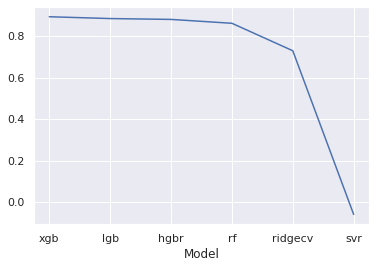

In [27]:
df_scores.set_index('Model')['AR2'].plot.line('ro')

# Fit the models and get train predictions

In [28]:
%%time
ridge.fit(df_Xtrain,ser_ytrain);
ypreds_ridge_tr = ridge.predict(np.array(df_Xtrain))
ypreds_ridge = ridge.predict(np.array(df_Xtest))
print(ypreds_ridge[:3])

[335389.60560525 282141.42552142 541400.38363095]
CPU times: user 84.9 ms, sys: 13.2 ms, total: 98.1 ms
Wall time: 79.4 ms


In [29]:
%%time
svr.fit(df_Xtrain,ser_ytrain);
ypreds_svr_tr = svr.predict(np.array(df_Xtrain))
ypreds_svr = svr.predict(np.array(df_Xtest))
print(ypreds_svr[:3])

[450141.29311464 449832.11309412 449747.37522329]
CPU times: user 1min 24s, sys: 147 ms, total: 1min 25s
Wall time: 1min 25s


In [30]:
%%time
rf.fit(df_Xtrain,ser_ytrain);
ypreds_rf_tr = rf.predict(np.array(df_Xtrain))
ypreds_rf = rf.predict(np.array(df_Xtest))
print(ypreds_rf[:3])

[456327.87376877 283476.94243856 635318.60020837]
CPU times: user 6min 38s, sys: 850 ms, total: 6min 39s
Wall time: 3min 23s


In [31]:
%%time
hgbr.fit(df_Xtrain,ser_ytrain);
ypreds_hgbr_tr = hgbr.predict(np.array(df_Xtrain))
ypreds_hgbr = hgbr.predict(np.array(df_Xtest))
print(ypreds_hgbr[:3])

[451353.8127617  241547.43807484 627812.38073368]
CPU times: user 13.6 s, sys: 549 ms, total: 14.2 s
Wall time: 7.19 s


In [32]:
%%time
model_xgb.fit(df_Xtrain,ser_ytrain);
ypreds_xgb_tr = model_xgb.predict(df_Xtrain)
ypreds_xgb = model_xgb.predict(df_Xtest
print(ypreds_xgb[:3])

[426671.88 226058.23 657271.94]
CPU times: user 3.81 s, sys: 1.47 s, total: 5.28 s
Wall time: 4.32 s


In [33]:
%%time
model_lgb.fit(df_Xtrain,ser_ytrain);
ypreds_lgb_tr = model_lgb.predict(df_Xtrain)
ypreds_lgb = model_lgb.predict(df_Xtest)
print(ypreds_lgb[:3])

[462712.84745236 241481.95596867 625092.40174866]
CPU times: user 1.47 s, sys: 28.3 ms, total: 1.5 s
Wall time: 782 ms


In [34]:
%%time
stack.fit(np.array(df_Xtrain),np.array(ser_ytrain))
ypreds_stack_tr = stack.predict(np.array(df_Xtrain))
ypreds_stack = stack.predict(np.array(df_Xtest))
print(ypreds_stack[:3])

[436236.12 243619.47 671034.6 ]
CPU times: user 38min 5s, sys: 16.3 s, total: 38min 21s
Wall time: 21min 58s


In [35]:
def get_rmse(y, y_pred):
    return np.sqrt(metrics.mean_squared_error(y, y_pred))

In [36]:
ytrain = np.array(ser_ytrain)
nrows = df_Xtrain.shape[0]
kcols = df_Xtrain.shape[1]

In [37]:
rmse_stack = get_rmse(ytrain, ypreds_stack_tr)
r2_stack = metrics.r2_score(ytrain, ypreds_stack_tr)
ar2_stack = calculate_adjusted_r2(ytrain,ypreds_stack_tr,nrows=nrows,kcols=kcols)

In [38]:
df_scores.loc[len(df_scores)] = ['stack',rmse_stack,0,r2_stack,0,ar2_stack,0,0]
df_scores = df_scores.drop_duplicates()

df_scores

,Model,RMSE,RMSE_std,R2,R2_std,AR2,AR2_std,Time_Taken
0,xgb,119199.799219,9254.005293,0.894148,0.008395,0.893656,0.008434,21.35 sec
1,lgb,124071.728335,10308.313206,0.885426,0.009260,0.884893,0.009303,3.07 sec
2,hgbr,126261.704246,12245.466500,0.881324,0.012921,0.880773,0.012981,17.89 sec
3,rf,135920.107162,11738.357882,0.862746,0.008494,0.862108,0.008534,13 min 36.69 sec
4,ridgecv,189758.231555,8600.010679,0.730846,0.019707,0.729594,0.019798,10.35 sec
5,svr,376429.355688,21585.860437,-0.055181,0.005707,-0.060086,0.005734,3 min 0.84 sec
6,stack,67252.233205,0.000000,0.966442,0.000000,0.966286,0.000000,0


## Blend models and get predictions

In [39]:
df_scores.sort_values('AR2',ascending=False)

,Model,RMSE,RMSE_std,R2,R2_std,AR2,AR2_std,Time_Taken
6,stack,67252.233205,0.000000,0.966442,0.000000,0.966286,0.000000,0
0,xgb,119199.799219,9254.005293,0.894148,0.008395,0.893656,0.008434,21.35 sec
1,lgb,124071.728335,10308.313206,0.885426,0.009260,0.884893,0.009303,3.07 sec
2,hgbr,126261.704246,12245.466500,0.881324,0.012921,0.880773,0.012981,17.89 sec
3,rf,135920.107162,11738.357882,0.862746,0.008494,0.862108,0.008534,13 min 36.69 sec
4,ridgecv,189758.231555,8600.010679,0.730846,0.019707,0.729594,0.019798,10.35 sec
5,svr,376429.355688,21585.860437,-0.055181,0.005707,-0.060086,0.005734,3 min 0.84 sec


In [40]:
x = df_scores.query("""
Model in ['rf', 'xgb', 'lgb', 'hgbr', 'ridge', 'svr','stack']
""")

x = x.sort_values('RMSE')
x

,Model,RMSE,RMSE_std,R2,R2_std,AR2,AR2_std,Time_Taken
6,stack,67252.233205,0.000000,0.966442,0.000000,0.966286,0.000000,0
0,xgb,119199.799219,9254.005293,0.894148,0.008395,0.893656,0.008434,21.35 sec
1,lgb,124071.728335,10308.313206,0.885426,0.009260,0.884893,0.009303,3.07 sec
2,hgbr,126261.704246,12245.466500,0.881324,0.012921,0.880773,0.012981,17.89 sec
3,rf,135920.107162,11738.357882,0.862746,0.008494,0.862108,0.008534,13 min 36.69 sec
5,svr,376429.355688,21585.860437,-0.055181,0.005707,-0.060086,0.005734,3 min 0.84 sec


In [41]:
x['normalized'] = x['RMSE'].div(x['RMSE'].sum()).to_numpy()[::-1].round(2)
x

,Model,RMSE,RMSE_std,R2,R2_std,AR2,AR2_std,Time_Taken,normalized
6,stack,67252.233205,0.000000,0.966442,0.000000,0.966286,0.000000,0,0.40
0,xgb,119199.799219,9254.005293,0.894148,0.008395,0.893656,0.008434,21.35 sec,0.14
1,lgb,124071.728335,10308.313206,0.885426,0.009260,0.884893,0.009303,3.07 sec,0.13
2,hgbr,126261.704246,12245.466500,0.881324,0.012921,0.880773,0.012981,17.89 sec,0.13
3,rf,135920.107162,11738.357882,0.862746,0.008494,0.862108,0.008534,13 min 36.69 sec,0.13
5,svr,376429.355688,21585.860437,-0.055181,0.005707,-0.060086,0.005734,3 min 0.84 sec,0.07


In [42]:
x['normalized'].sum()

1.0

In [43]:
x['Model'].to_numpy()

array(['stack', 'xgb', 'lgb', 'hgbr', 'rf', 'svr'], dtype=object)

In [49]:
# training data predictions
preds = np.c_[ypreds_stack_tr, ypreds_xgb_tr,ypreds_lgb_tr,ypreds_hgbr_tr,ypreds_rf_tr,ypreds_svr_tr]
weights = x['normalized'].to_numpy()

print('preds shape       :', preds.shape)
print('weights shape     :', weights.shape)
print('ypreds_stack shape:', ypreds_stack.shape )

ypreds_blend = np.dot(preds, weights.reshape(-1,1)).flatten()
ypreds_blend[:3]

preds shape       : (17290, 6)
weights shape     : (6,)
ypreds_stack shape: (17290,)


array([443889.69243579, 260230.01197176, 637383.27726542])

In [50]:
rmse_blend = get_rmse(ytrain, ypreds_blend)
r2_blend = metrics.r2_score(ytrain, ypreds_blend)
ar2_blend = calculate_adjusted_r2(ytrain,ypreds_blend,nrows=nrows,kcols=kcols)

In [51]:
df_scores

,Model,RMSE,RMSE_std,R2,R2_std,AR2,AR2_std,Time_Taken
0,xgb,119199.799219,9254.005293,0.894148,0.008395,0.893656,0.008434,21.35 sec
1,lgb,124071.728335,10308.313206,0.885426,0.009260,0.884893,0.009303,3.07 sec
2,hgbr,126261.704246,12245.466500,0.881324,0.012921,0.880773,0.012981,17.89 sec
3,rf,135920.107162,11738.357882,0.862746,0.008494,0.862108,0.008534,13 min 36.69 sec
4,ridgecv,189758.231555,8600.010679,0.730846,0.019707,0.729594,0.019798,10.35 sec
5,svr,376429.355688,21585.860437,-0.055181,0.005707,-0.060086,0.005734,3 min 0.84 sec
6,stack,67252.233205,0.000000,0.966442,0.000000,0.966286,0.000000,0


In [52]:
df_scores.loc[len(df_scores)] = ['blend',rmse_blend,0,r2_blend,0,ar2_blend,0,'7min']
df_scores = df_scores.drop_duplicates().sort_values('RMSE')

In [53]:
display(df_scores.style
        .format({
            'RMSE': "{:,.0f}",
            'RMSE_std': "{:,.0f}",
            'R2': "{:,.4f}",
            'R2_std': "{:,.4f}",
            'AR2': "{:,.4f}",
            'AR2_std': "{:,.4f}",
            })
        .background_gradient(subset=['AR2'])
        .set_caption('Model evaluation for Train set')
        )

,Model,RMSE,RMSE_std,R2,R2_std,AR2,AR2_std,Time_Taken
6,stack,"67,252",0,0.9664,0.0000,0.9663,0.0000,0
7,blend,"75,297",0,0.9579,0.0000,0.9577,0.0000,7min
0,xgb,"119,200","9,254",0.8941,0.0084,0.8937,0.0084,21.35 sec
1,lgb,"124,072","10,308",0.8854,0.0093,0.8849,0.0093,3.07 sec
2,hgbr,"126,262","12,245",0.8813,0.0129,0.8808,0.0130,17.89 sec
3,rf,"135,920","11,738",0.8627,0.0085,0.8621,0.0085,13 min 36.69 sec
4,ridgecv,"189,758","8,600",0.7308,0.0197,0.7296,0.0198,10.35 sec
5,svr,"376,429","21,586",-0.0552,0.0057,-0.0601,0.0057,3 min 0.84 sec


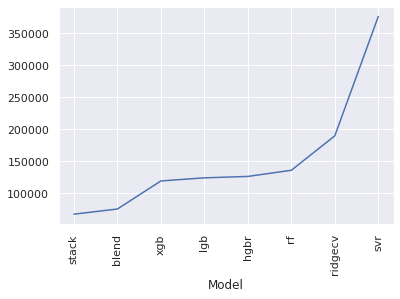

In [54]:
df_scores.set_index('Model')['RMSE'].plot.line('ro',rot=90)

# Model Predictions on Test Data

In [55]:
def adjustedR2(rsquared,nrows,kcols):
    return rsquared- (kcols-1)/(nrows-kcols) * (1-rsquared)

In [56]:
model_names = ['ridge','svr','rf','hgbr','xgboost','lightgbm','stack']

In [64]:
ypreds = [ypreds_ridge, ypreds_svr,ypreds_rf,ypreds_hgbr,
          ypreds_xgb, ypreds_lgb,ypreds_stack]

rmses = [get_rmse(np.array(ser_ytest), yp) for yp in ypreds]
r2s = [sklearn.metrics.r2_score(np.array(ser_ytest), yp) for yp in ypreds]

ar2s = [adjustedR2(r2, nrows=df_Xtest.shape[0], kcols=df_Xtest.shape[1]) for r2 in r2s]

In [65]:
df_eval = pd.DataFrame({'Model': model_names,
                        'RMSE': rmses,
                        'R-squared': r2s,
                        'Adjusted-Rsquared': ar2s})

df_eval = df_eval.sort_values('RMSE',ascending=True)

In [66]:
display(df_eval.style
        .format({
            'RMSE': "{:,.0f}",
            'RMSE_std': "{:,.0f}",
            'R2': "{:,.4f}",
            'R2_std': "{:,.4f}",
            'AR2': "{:,.4f}",
            'AR2_std': "{:,.4f}",
            })
        .background_gradient(subset=['Adjusted-Rsquared'])
        .set_caption('Model evaluation for Test set')
        )

,Model,RMSE,R-squared,Adjusted-Rsquared
6,stack,"119,463",0.894104,0.892107
4,xgboost,"119,725",0.893639,0.891634
5,lightgbm,"125,401",0.883315,0.881115
3,hgbr,"127,325",0.879709,0.877440
2,rf,"131,855",0.870997,0.868564
0,ridgecv,"191,052",0.729160,0.724052
1,svr,"377,376",-0.056717,-0.076646


# Time Taken

In [67]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 1 hr 5 min 57 secs
